# Initialising ML-Ensemble in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [6]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm", title=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.suptitle(title, y=0.85)

    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [7]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [8]:
def imshowSim(sim, eta_vlim=0.05, huv_lim=2.0):
    eta, hu, hv = sim.download(interior_domain_only=False)
    return imshow3(np.array([eta, hu, hv]), eta_vlim=eta_vlim, huv_vlim=huv_lim)

### Perturbing initial conditions

In [9]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [10]:
ls = [6, 7, 8, 9, 10]

In [11]:
model_error_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    model_error_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [12]:
model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.005,
}

In [13]:
mekls = []
for l_idx in range(len(ls)): 
    mekls.append( ModelErrorKL.ModelErrorKL(**model_error_args_list[l_idx], **model_error_basis_args) 
                )

### Ensemble

In [14]:
timestamp = "2023-04-25T10_01_53"

vars = np.load("vars_"+timestamp+".npy")
diff_vars = np.load("diff_vars_"+timestamp+".npy")

In [15]:
from utils.BasinAnalysis import *

In [16]:
analysis = Analysis(ls, vars, diff_vars, model_error_args_list)

In [17]:
ML_Nes = analysis.optimal_Ne(tau=5e-5)
ML_Nes

array([10197,   376,    95,    24,     6], dtype=int32)

### Ensemble

In [18]:
from utils.BasinEnsembleInit import *

In [19]:
ML_ensemble = initMLensemble(ls, ML_Nes, model_error_args_list, model_error_basis_args, sample_args)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100


In [20]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [21]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

### Statistics

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

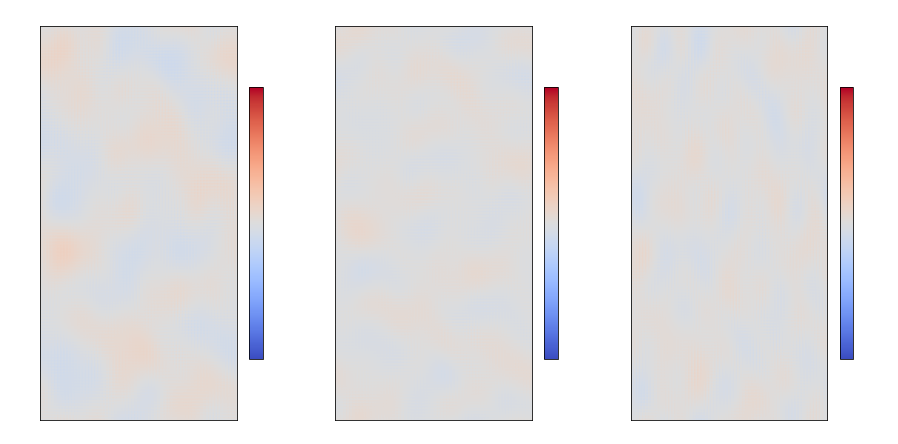

In [22]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=5e-4, huv_vlim=5e-2)

In [23]:
ML_state = MLOceanEnsemble.download()

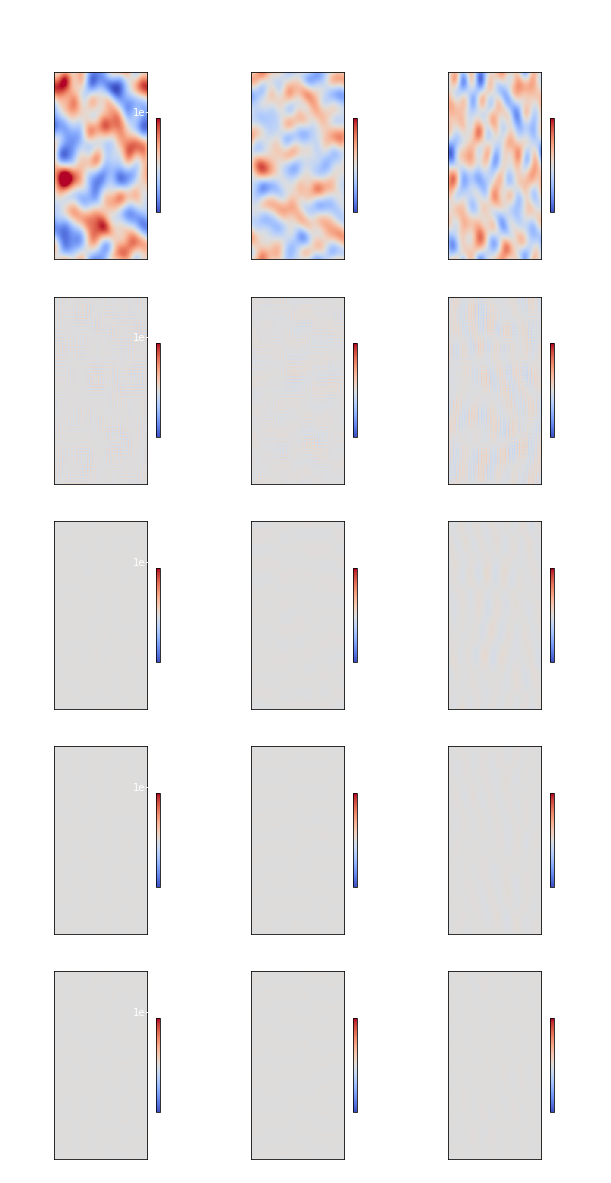

In [24]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Means per level",y=0.925)

eta_vlim = 5e-5
huv_lim = 5e-3

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.mean(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=-eta_vlim, vmax=eta_vlim, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=-huv_lim, vmax=huv_lim, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=-huv_lim, vmax=huv_lim, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.mean(ML_state[l_idx][0],axis=-1) - np.mean(ML_state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-eta_vlim, vmax=eta_vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-huv_lim, vmax=huv_lim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-huv_lim, vmax=huv_lim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

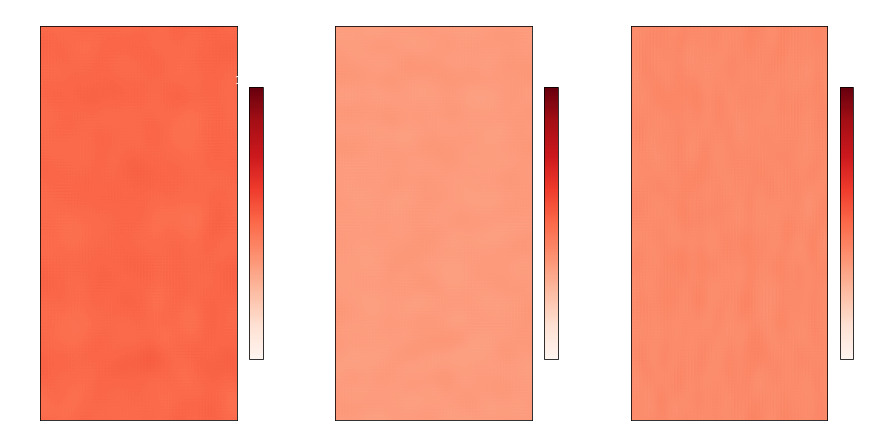

In [25]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=1e-5, huv_lim=5e-2)

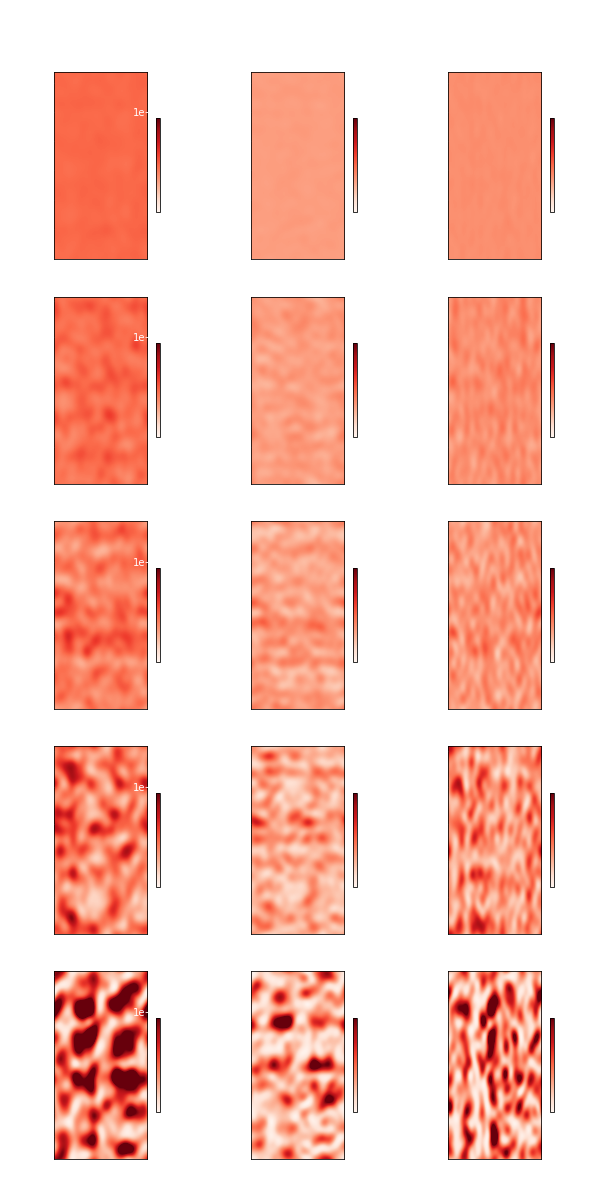

In [26]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Vars per level",y=0.925)

eta_vlim=1e-5
huv_lim=5e-2

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.var(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=0.0, vmax=eta_vlim, cmap="Reds")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=0, vmax=huv_lim, cmap="Reds")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=0, vmax=huv_lim, cmap="Reds")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.var(ML_state[l_idx][0],axis=-1)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=0.0, vmax=eta_vlim, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=0, vmax=huv_lim, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=0, vmax=huv_lim, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

### Rank histograms

In [27]:
freq = 50
Hxs = np.arange( 512, 1024, freq)
Hys = np.arange(1024, 2048, 2*freq)

In [28]:
N_ranks = 100

In [29]:
ML_ranks = np.zeros((len(Hxs)*N_ranks,3))

In [30]:
data_args = make_init_fields(model_error_args_list[-1])
sim = make_sim(model_error_args_list[-1], sample_args, init_fields=data_args)

mekl = ModelErrorKL.ModelErrorKL(**model_error_args_list[-1], **model_error_basis_args)
mekl.perturbSim(sim)

In [31]:
true_diag = np.zeros((N_ranks, 3, 1024))

In [32]:
for n in range(N_ranks):
    print(n)
    # new truth
    data_args = make_init_fields(model_error_args_list[-1])
    sim = make_sim(model_error_args_list[-1], sample_args, init_fields=data_args)

    mekl = ModelErrorKL.ModelErrorKL(**model_error_args_list[-1], **model_error_basis_args)
    mekl.perturbSim(sim)
    # ranks
    ML_ranks[n*len(Hxs):(n+1)*len(Hxs)] = MLOceanEnsemble.rank(sim, [z for z in zip(Hxs, Hys)])

    # saving true diagonal
    true_diag[n] = [np.diag(v[::2,::1]) for v in sim.download(interior_domain_only=True)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
import datetime
dumptime = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
np.save("dumpRanks_"+dumptime, ML_ranks)

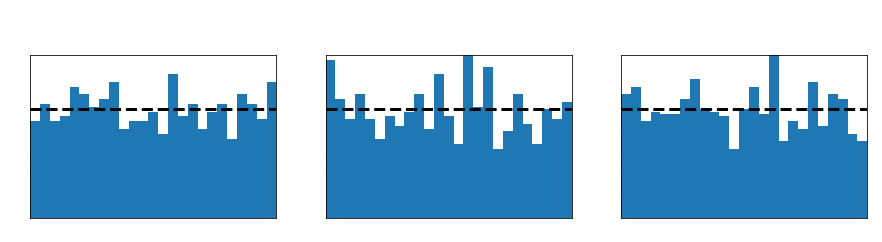

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ML ranks",y=1.1)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

bins_size= 1/25
bins = np.arange(0,1+1e-9,bins_size)

for i in range(3):
    hist = np.histogram(ML_ranks[:,i], bins=bins)
    axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0]/len(ML_ranks)/bins_size, width=bins_size, color="C0")
    
    axs[i].set_ylim((0,1.5))
    axs[i].set_xlim((0,1.0))

    axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

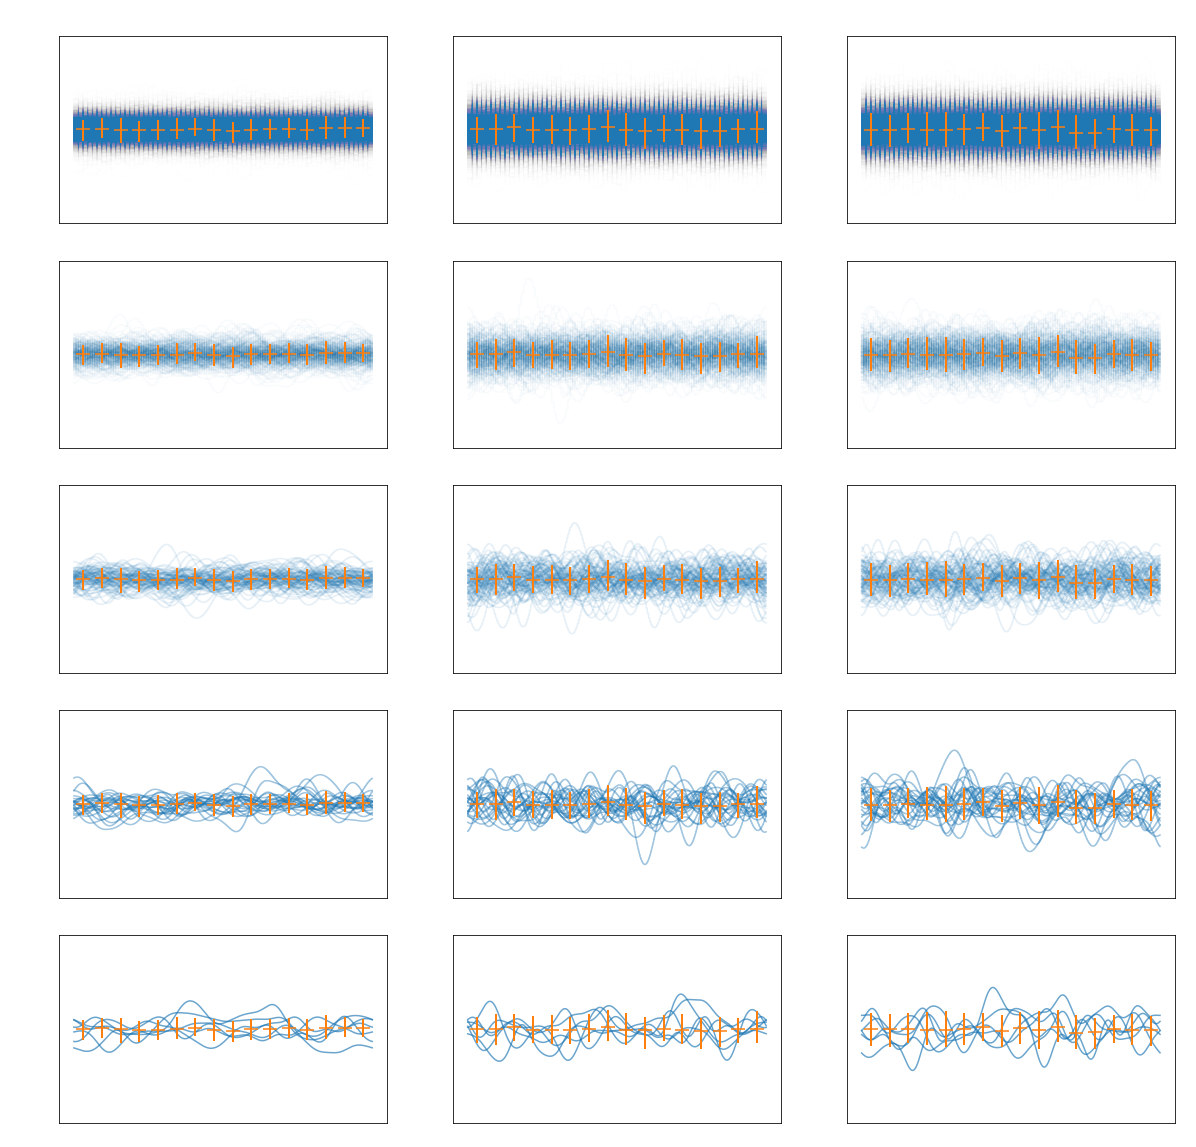

In [41]:
fig, axs = plt.subplots(len(ls),3, figsize=(20,20))
fig.suptitle("Cut along the diagonal",  y=0.9)

# levels
for l_idx in range(len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))

    # level state
    if l_idx == 0:
        l_state = ML_state[0]
    else:
        l_state = ML_state[l_idx][0]


    # eta hu hv
    for v in range(3):
        if v == 0:
            axs[l_idx,v].set_ylim((-0.025,0.025))
        else:
            axs[l_idx,v].set_ylim((-1,1))

        # ensemble member
        for e in range(ML_Nes[l_idx]):
            axs[l_idx,v].plot( np.diag(l_state[v,::2,::1,e]).repeat(2**(ls[-1]-ls[l_idx])), alpha=np.maximum(10/ML_Nes[l_idx],0.005), c="C0", zorder=1)

        for diag_loc in range(32,1024,64):
            loc_truthes = np.moveaxis(true_diag,0,-1)[v,diag_loc,:]
            low, mean, up = np.quantile(loc_truthes, 0.1), np.mean(loc_truthes),np.quantile(loc_truthes,0.9)
            axs[l_idx,v].scatter(diag_loc, mean, c="C1", marker="_", s=200, zorder=3)
            axs[l_idx,v].vlines(x=diag_loc, ymin=low, ymax=up, colors="C1", lw=2, zorder=2)
    